## DeepExplain - Inception V3 for natural image classification
### Comparison of classic and adversarially trained models for Tensorflow-Slim Inception V3

In [1]:
'''
%%bash
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz -C data/models
rm inception_v3_2016_08_28.tar.gz

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C data/models
rm adv_inception_v3_2017_08_18.tar.gz'''

'\n%%bash\n# Download TF checkpoints in data/models folder\n\nwget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz\ntar -xvzf inception_v3_2016_08_28.tar.gz -C data/models\nrm inception_v3_2016_08_28.tar.gz\n\nwget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz\ntar -xvzf adv_inception_v3_2017_08_18.tar.gz -C data/models\nrm adv_inception_v3_2017_08_18.tar.gz'

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
from scipy.misc import imread
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception

slim = tf.contrib.slim
    
from deepexplain.tensorflow import DeepExplain

/users/jocelins/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Define aux function to import images in batches
def load_images():
    NUM = 1
    images = np.zeros((4*NUM, 299, 299, 3))
    #images = np.zeros((1, 299, 299, 3))
    filenames = []
    idx = 0
    #'''
    for filepath in tf.gfile.Glob(os.path.join('data/images', '*.png')):
        with tf.gfile.Open(filepath,'rb') as f:
            image = imread(f, mode='RGB').astype(np.float) / 255.0
        # Images for inception classifier are normalized to be in [-1, 1] interval.
        for i in range(idx, idx+NUM):
            images[idx, :, :, :] = image * 2.0 - 1.0
            filenames.append(os.path.basename(filepath))
        idx += 1*NUM 
    #'''
    '''
    for i in range(3):
        filepath = tf.gfile.Glob(os.path.join('data/images', '*.png'))[i]
        with tf.gfile.Open(filepath,'rb') as f:
            image = imread(f, mode='RGB').astype(np.float) / 255.0
            # Images for inception classifier are normalized to be in [-1, 1] interval.
            images[i, :, :, :] = image * 2.0 - 1.0
            filenames.append(os.path.basename(filepath))
    '''
    return filenames, images

In [4]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = 'data/models/inception_v3.ckpt'
# checkpoint = 'data/models/adv_inception_v3.ckpt'

tf.reset_default_graph()
sess = tf.Session()

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    yi = tf.argmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    filenames, xs = load_images()
    labels = sess.run(yi, feed_dict={X: xs})
    print (filenames, labels)

INFO:tensorflow:Restoring parameters from data/models/inception_v3.ckpt


/users/jocelins/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


['0c7ac4a8c9dfa802.png', '5b3a8c63e41802e7.png', '4fc263d35a3ad3ee.png', '1c2e9fe8b0b2fdf2.png'] [306 750 244  58]


In [5]:
# Compute attributions for the classified images
# Every DeepExplain method must be called in a DeepExplain context.
# In this case, we use two different contexts to create the model and to 
# run the explanation methods. This works as long as the same session is provided.
import time
import cProfile

methods = [('Saliency maps', 'saliency'), 
           ('Gradient * Input', 'grad*input'), 
           ('Integrated Gradients','intgrad'),
          ('Epsilon-LRP','elrp'), 
           ('DeepLIFT (Rescale)','deeplift'),
          ('Integrated DeepLIFT', 'integdeeplift')]#, ('Integrated DeepLIFT','integdeeplift')]
testing = [4]
    
with DeepExplain(session=sess) as de:
    '''
    attributions = {}
    
    times = [time.time()]
    for i in testing:
        name1 = methods[i][0]
        name2 = methods[i][1]
        attributions[name1] = de.explain(name2, tf.reduce_max(logits, 1), X, xs)
        times.append(time.time())
        print(name1, times[-1] - times[-2])
        
    attributions['Integrated DeepLIFT'] = de.explain('integdeeplift', tf.reduce_max(logits, 1), X, xs, steps=100)
    times.append(time.time())
    '''
    #print('Integrated DeepLIFT', times[-1] - times[-2])
    #cProfile.run("de.explain('integdeeplift', tf.reduce_max(logits, 1), X, xs, steps=100)")
    #'''
    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        #'Saliency maps':        de.explain('saliency', tf.reduce_max(logits, 1), X, xs),
        #'Gradient * Input':     de.explain('grad*input', tf.reduce_max(logits, 1), X, xs),
        #'Integrated Gradients': de.explain('intgrad', tf.reduce_max(logits, 1), X, xs),
        #'Epsilon-LRP':          de.explain('elrp', tf.reduce_max(logits, 1), X, xs),
        
        'Integrated DeepLIFT 1':   de.explain('integdeeplift', tf.reduce_max(logits, 1), X, xs, steps=1),
        'DeepLIFT (Rescale)':   de.explain('deeplift', tf.reduce_max(logits, 1), X, xs),
        'Integrated DeepLIFT 10':   de.explain('integdeeplift', tf.reduce_max(logits, 1), X, xs, steps=10),
        'Integrated DeepLIFT 100':   de.explain('integdeeplift', tf.reduce_max(logits, 1), X, xs, steps=100),
        'Integrated Gradients': de.explain('intgrad', tf.reduce_max(logits, 1), X, xs),
        # Perturbation-based (comment out to evaluate, but this will take a while!)
        # 'Occlusion [15x15]':    de.explain('occlusion', tf.reduce_max(logits, 1), X, xs, window_shape=(15,15,3), step=4)
    }#'''
    print ("Done!")

DeepExplain: running "integdeeplift" explanation method (7)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "integdeeplift" explanation method (7)
Model with multiple inputs:  False
DeepExplain: running "integdeeplift" explanation method (7)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
Done!


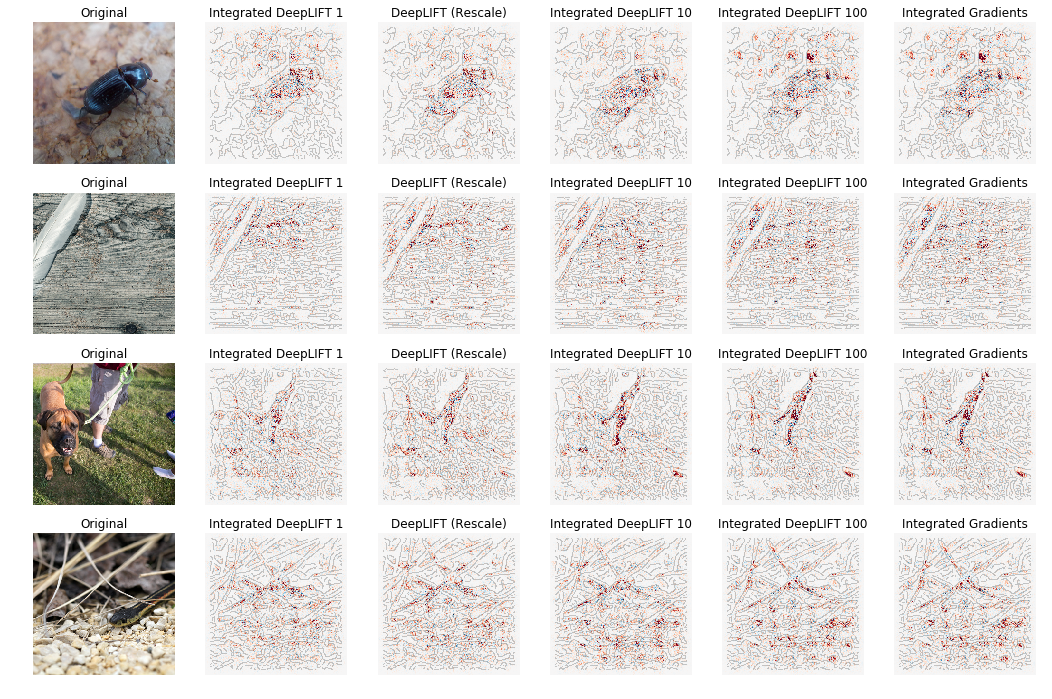

In [6]:
# Plot attributions
from utils import plot, plt
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = len(xs) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, a in enumerate(attributions):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi = xi, axis=axj, dilation=.5, percentile=99, alpha=.2).set_title(a)